# Quarto

In [1]:
import logging
import argparse
import random
import quarto
from collections import namedtuple
import matplotlib.pyplot as plt

In [10]:
logging.basicConfig(format="%(message)s", level=logging.INFO)

## An agent using fixed rules

### The random player

In [11]:
class RandomPlayer(quarto.Player):
    """Random player"""

    def __init__(self, quarto: quarto.Quarto) -> None:
        super().__init__(quarto)

    def choose_piece(self) -> int:
        return random.randint(0, 15)

    def place_piece(self) -> tuple[int, int]:
        return random.randint(0, 3), random.randint(0, 3)

### Some hardcoded strategies

In [12]:
def get_lowest_row(game: quarto.Quarto, action=None) -> tuple[int, int]:
    board = game.get_board_status()
    for x in range(game.BOARD_SIDE):
        for y in range(game.BOARD_SIDE):
            if board[y, x] == -1: return x, y
    return None, None

def get_highest_row(game: quarto.Quarto, action=None) -> tuple[int, int]:
    board = game.get_board_status()
    for x in reversed(range(game.BOARD_SIDE)):
        for y in range(game.BOARD_SIDE):
            if board[y, x] == -1: return x, y
    return None, None

def get_middle_row(game: quarto.Quarto, action=None) -> tuple[int, int]:
    board = game.get_board_status()
    for x in [1, 2, 0, 3]:
        for y in range(game.BOARD_SIDE):
            if board[y, x] == -1: return x, y
    return None, None

def get_lowest_column(game: quarto.Quarto, action=None) -> tuple[int, int]:
    board = game.get_board_status()
    for y in range(game.BOARD_SIDE):
        for x in range(game.BOARD_SIDE):
            if board[y, x] == -1: return x, y
    return None, None

def get_highest_column(game: quarto.Quarto, action=None) -> tuple[int, int]:
    board = game.get_board_status()
    for y in reversed(range(game.BOARD_SIDE)):
        for x in range(game.BOARD_SIDE):
            if board[y, x] == -1: return x, y
    return None, None

def get_middle_column(game: quarto.Quarto, action=None) -> tuple[int, int]:
    board = game.get_board_status()
    for y in [1, 2, 0, 3]:
        for x in range(game.BOARD_SIDE):
            if board[y, x] == -1: return x, y
    return None, None

def get_lowest_coordinates(game: quarto.Quarto, action=None) -> tuple[int, int]:
    board = game.get_board_status()
    sum = game.BOARD_SIDE**2
    coordinates = None, None
    for y in range(game.BOARD_SIDE):
        for x in range(game.BOARD_SIDE):
            if board[y, x] == -1:
                if sum > x + y:
                    sum = x + y
                    coordinates = x, y
    return coordinates

def get_highest_coordinates(game: quarto.Quarto, action=None) -> tuple[int, int]:
    board = game.get_board_status()
    sum = -1
    coordinates = None, None
    for y in reversed(range(game.BOARD_SIDE)):
        for x in reversed(range(game.BOARD_SIDE)):
            if board[y, x] == -1:
                if sum < x + y:
                    sum = x + y
                    coordinates = x, y
    return coordinates

def get_middle_coordinates(game: quarto.Quarto, action=None) -> tuple[int, int]:
    board = game.get_board_status()
    first_ring = [(1, 1), (1, 2), (2, 1), (2, 2)]
    for x, y in first_ring:
        if board[y, x] == -1: return x, y
    second_ring = [(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 3), (2, 0), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]
    for x, y in second_ring:
        if board[y, x] == -1: return x, y
    return None, None

def get_fill_coordinates(game: quarto.Quarto, action="fill") -> tuple[int, int]:
    '''action can be "fill" or "unfill"'''
    assert action == "fill" or action == "unfill"

    min_or_max = min if action == "unfill" else max
    board = game.get_board_status()
    sum_rows = {}
    sum_columns = {}
    sum_first_diagonal = 4
    sum_second_diagonal = 4
    c_row = {}
    c_column = {}
    c_first_diagonal = None, None
    c_second_diagonal = None, None
    
    for x in range(game.BOARD_SIDE):
        for y in range(game.BOARD_SIDE):
            if board[y, x] == -1:
                if x not in sum_rows: sum_rows[x] = 4
                if y not in sum_columns: sum_columns[y] = 4
                sum_rows[x] -= 1
                c_row[x] = x, y
                sum_columns[y] -= 1
                c_column[y] = x, y
                if (x == 3 and y == 0) or (x == 2 and y == 1) or (x == 1 and y == 2) or (x == 0 and y == 3):
                    sum_first_diagonal -= 1
                    c_first_diagonal = x, y
                elif x == y:
                    sum_second_diagonal -= 1
                    c_second_diagonal = x, y
    max_row = min_or_max(sum_rows, key=sum_rows.get) if len(sum_rows) != 0 else None
    max_column = min_or_max(sum_columns, key=sum_columns.get) if len(sum_columns) != 0 else None
    dictionary = {}
    if max_row != None: dictionary[0] = sum_rows[max_row]
    if max_column != None: dictionary[1] = sum_columns[max_column]
    if sum_first_diagonal != 4: dictionary[2] = sum_first_diagonal
    if sum_second_diagonal != 4: dictionary[3] = sum_second_diagonal

    max_ = min_or_max(dictionary, key=dictionary.get) if len(dictionary) != 0 else None
    if max_ == 0: return c_row[max_row]
    elif max_ == 1: return c_column[max_column]
    elif max_ == 2: return c_first_diagonal
    elif max_ == 3: return c_second_diagonal
    else: 
        return None, None

In [13]:
def get_most_common_piece(game: quarto.Quarto, action="common") -> int:
    '''action can be "common" or "uncommon"'''
    assert action == "common" or action == "uncommon"

    high = 0
    coloured = 0
    solid = 0
    square = 0
    pieces = list(range(16))
    board = game.get_board_status()
    for x in range(game.BOARD_SIDE):
        for y in range(game.BOARD_SIDE):
            piece = board[y, x]
            if piece != -1:
                pieces.remove(piece)
                if piece & 1 == 1: square += 1
                if piece & 2 == 2: solid += 1
                if piece & 4 == 4: coloured += 1
                if piece & 8 == 8: high += 1
    properties = {}
    if high != 8: properties[8] = high
    if coloured != 8: properties[4] = coloured
    if solid != 8: properties[2] = solid
    if square != 8: properties[1] = square
    sorted_keys = sorted(properties, key=properties.get, reverse=(action=="common"))
    for piece in pieces:
        try:
            if piece & sorted_keys[0] == sorted_keys[0]:
                return piece
        except:
            # sorted_keys can have 0 length, this is due to the fact that piece 0 has False to all the properties
            # This happens only if 0 is the last piece remaining
            return piece
    return pieces[0] if len(pieces) != 0 else None

def get_most_similar_piece(game: quarto.Quarto, action="similar"):
    '''action can be "similar" or "different"'''
    assert action == "similar" or action == "different"

    board = game.get_board_status()
    last_piece = game.get_selected_piece()
    pieces = list(range(16))
    for x in range(game.BOARD_SIDE):
        for y in range(game.BOARD_SIDE):
            piece = board[y, x]
            if piece != -1:
                pieces.remove(piece)
    best = None
    similarity = 0 if action == "similar" else game.BOARD_SIDE**2
    for piece in pieces:
        current = 1
        if piece & 1 == last_piece & 1: current += 1
        if piece & 2 == last_piece & 2: current += 1
        if piece & 4 == last_piece & 4: current += 1
        if piece & 8 == last_piece & 8: current += 1
        if action == "similar" and current > similarity:
            best = piece
            similarity = current
        if action == "different" and current < similarity:
            best = piece
            similarity = current
    return best

### The hardcoded player

In [14]:
class HardcodedPlayer(quarto.Player):
    """Random player"""

    def __init__(self, quarto: quarto.Quarto, choose_strategy, place_strategy) -> None:
        super().__init__(quarto)
        self.choose_strategy = choose_strategy[0]
        self.choose_action = choose_strategy[1]
        self.place_strategy = place_strategy[0]
        self.place_action = place_strategy[1]

    def choose_piece(self) -> int:
        return self.choose_strategy(self.get_game(), self.choose_action)

    def place_piece(self) -> tuple[int, int]:
        return self.place_strategy(self.get_game(), self.place_action)

## An agent using evolved rules

### Individual
An individual is formed by two lists:
- The first one contains four numbers that refer to the choosing phase.
- The second one contains eleven numbers that refer to the placing phase.

Each number represents the probability that a certain strategy will be chosen.

In [17]:
Individual = namedtuple("Individual", ["genome", "fitness"])

### Evolved strategy
It is a method that can be used both in the choosing and in the placing phase.<br>
It takes as argument one of the two lists of the individual, then generate a random number, and uses it to return an appropriate result (coordinates or piece index) based on the chosen strategy.

In [18]:
def get_evolved_strategy(game: quarto.Quarto, half_individual, action="place"):
    '''action can be "place" or "choose"'''
    # half_individual is made of probabilities in [0.0, 1.0] (with 1 decimal digit)
    assert action == "place" or action == "choose"
    assert len(half_individual) == (4 if action == "choose" else 11)

    if action == "choose":
        strategies = [get_most_common_piece, get_most_common_piece, get_most_similar_piece, get_most_similar_piece]
        actions = ["common", "uncommon", "similar", "different"]
    else:
        strategies = [get_lowest_row, get_highest_row, get_middle_row, get_lowest_column, get_highest_column, get_middle_column, get_lowest_coordinates, get_highest_coordinates, get_middle_coordinates, get_fill_coordinates, get_fill_coordinates]
        actions = [None, None, None, None, None, None, None, None, None, "fill", "unfill"]
    
    cumulated = list()
    for index, prob in enumerate(half_individual):
        if index == 0: cumulated.append(prob*10)
        else: cumulated.append(cumulated[index-1] + prob*10)
    
    rand = random.randint(0, cumulated[3 if action == "choose" else 10])
    for index, prob in enumerate(cumulated):
        if rand <= prob: return strategies[index](game, action=actions[index])
    max_ = cumulated[3 if action == "choose" else 10]
    return None if action == "choose" else None, None

### The evolved player

In [19]:
class EvolvedPlayer(quarto.Player):
    """Random player"""

    def __init__(self, quarto: quarto.Quarto, individual) -> None:
        super().__init__(quarto)
        self.choose_individual = individual[0]
        self.place_individual = individual[1]

    def choose_piece(self) -> int:
        return get_evolved_strategy(self.get_game(), self.choose_individual, "choose")

    def place_piece(self) -> tuple[int, int]:
        return get_evolved_strategy(self.get_game(), self.place_individual, "place")

### Cross-over
Given two individual, merge them by taking a random $num$ of propabilities of the first one and $NUM\_ROWS - num$ probabilities of the second one, twice (for both the lists in the individuals).

In [20]:
# returns individuals with max fitness (the fittest) but still random
def tournament(population, tournament_size=2):
    return max(random.choices(population, k=tournament_size), key=lambda i: i.fitness)

def cross_over(g1, g2):
    cut_choose = random.randint(0, 3)
    cut_place = random.randint(0, 10)
    return [
        g1[0][:cut_choose] + g2[0][cut_choose:],
        g1[1][:cut_place] + g2[1][cut_place:]
    ]

### Mutation
Replace a random probability of the individual with another random probability, twice (for both the lists of the individuals).

In [21]:
def mutation(g):
    point_choose = random.randint(0, 3)
    point_place = random.randint(0, 10)
    new_choose = random.randint(0, 10) / 10
    new_place = random.randint(0, 10) / 10
    return [
        g[0][:point_choose] + ([new_choose]) + g[0][point_choose + 1 :],
        g[1][:point_place] + ([new_place]) + g[1][point_place + 1 :]
    ]

### Fitness
The fitness is the winning ratio of the individual against the random agent in 200 matches.<br>
The evolved player makes the first move in half of the games.

In [22]:
def fitness(individual, num_matches=200):
    won = 0
    for match in range(num_matches):
        game = quarto.Quarto()
        if match % 2 == 0: game.set_players((EvolvedPlayer(game, individual), RandomPlayer(game)))
        else: game.set_players((RandomPlayer(game), EvolvedPlayer(game, individual)))

        if game.run() == match % 2: won += 1
    return won/num_matches

### Initial Population

In [23]:
POPULATION_SIZE = 50
OFFSPRING_SIZE = 17

NUM_GENERATIONS = 200
FITNESS_PRECISION = 100

In [16]:
population = list()
for index in range(POPULATION_SIZE):
    genome = [
        [random.randint(0, 10) / 10 for _ in range(4)],
        [random.randint(0, 10) / 10 for _ in range(11)]
    ]
    population.append(Individual(genome, fitness(genome, FITNESS_PRECISION)))

logging.info(f"init: pop_size={len(population)}; max={max(population, key=lambda i: i.fitness)[1]}")

init: pop_size=50; max=0.63


### Evolution Algorithm

In [17]:
fitness_log = [(0, i.fitness) for i in population]

mutation_rate = 0.3
for g in range(NUM_GENERATIONS):
    if g % 50 == 49: mutation_rate -= 0.5
    offspring = list()
    for i in range(OFFSPRING_SIZE):
        if random.random() < mutation_rate:
            p = tournament(population)
            o = mutation(p.genome)
        else:
            p1 = tournament(population)
            p2 = tournament(population)
            o = cross_over(p1.genome, p2.genome)
        f = fitness(o, num_matches=FITNESS_PRECISION)
        fitness_log.append((g + 1, f))
        offspring.append(Individual(o, f))
    for goff in offspring:
        if goff not in population:
            population.append(goff)
    population = sorted(population, key=lambda i: i.fitness, reverse=True)[:POPULATION_SIZE]

best_individual = max(population, key=lambda i: i.fitness)

logging.info(f"Number of generations: {NUM_GENERATIONS}")
logging.info(f"Population size: {POPULATION_SIZE}")
logging.info(f"Offspring size: {OFFSPRING_SIZE}\n")

logging.info(f"Best individual")
logging.info(f" Choose: {best_individual.genome[0]}")
logging.info(f" Place: {best_individual.genome[1]}")
logging.info(f" Fitness: {best_individual.fitness}")

Number of generations: 200
Population size: 50
Offspring size: 17

Best individual
 Choose: [0.5, 0.3, 0.1, 0.7]
 Place: [0.0, 0.3, 0.4, 0.6, 0.2, 0.3, 0.1, 0.2, 0.6, 1.0, 0.4]
 Fitness: 0.715


### Performance Evaluation

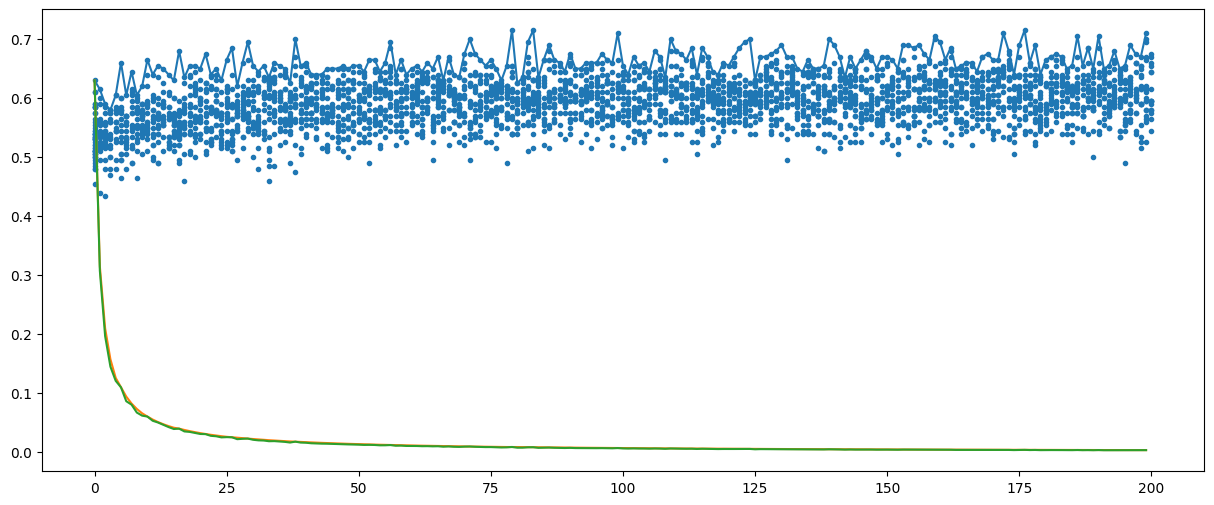

In [18]:
off_line = [max(f[1] for f in fitness_log if f[0] == x) / (x + 1) for x in range(NUM_GENERATIONS)]
on_line = [max(f[1] for f in fitness_log if f[0] <= x) / (x + 1) for x in range(NUM_GENERATIONS)]
gen_best = [max(f[1] for f in fitness_log if f[0] == x) for x in range(NUM_GENERATIONS)]

plt.figure(figsize=(15, 6))
plt.scatter([x for x, _ in fitness_log], [y for _, y in fitness_log], marker=".")
plt.plot([x for x, _ in enumerate(gen_best)], [y for _, y in enumerate(gen_best)])
plt.plot([x for x, _ in enumerate(on_line)], [y for _, y in enumerate(on_line)])
plt.plot([x for x, _ in enumerate(off_line)], [y for _, y in enumerate(off_line)])

### Results

| NUM_GENERATIONS | POPULATION_SIZE | OFFSPRING_SIZE | Mutation Rate | Best Fitness |   Time  |
| :-------------: | :-------------: | :------------: | :-----------: | :----------: | :-----: |
|       200       |        50       |       17       |      0.3      |     0.86     |  9m 3s  |
|       200       |        50       |       17       |   0.3 -> 0.1  |     0.81     |  9m 1s  |
|       200       |        50       |       17       |      0.4      |     0.78     |  9m 11s |
|       200       |        50       |       17       |   0.4 -> 0.2  |     0.78     |  9m 29s |
|       100       |        50       |       17       |      0.3      |     0.76     |  4m 34s |
|       200       |        50       |       17       |   0.2 -> 0.4  |     0.76     |  9m 21s |
|       200       |        50       |       17       |  0.25 -> 0.15 |     0.75     |  9m 39s |
|       300       |        50       |       17       |      0.3      |     0.75     | 13m 38s |
|       100       |        10       |        3       |      0.3      |     0.74     |   50s   |
|       500       |        10       |        3       |      0.3      |     0.74     |  4m 13s |
|       200       |        50       |       17       |   0.3 -> 0.5  |     0.73     |  9m 7s  |
|       100       |        30       |       10       |      0.3      |     0.72     |  2m 46s |
|       500       |        50       |       17       |      0.3      |     0.86     |  9m 3s  |

N.B. The fitness refers to the approximated one.

### Further evaluations

A more accurate fitness

In [41]:
fitness(best_individual.genome, num_matches=10000)

0.5773

A tournament against all the hardcoded strategies

In [ ]:
choose_strategies = [get_most_common_piece, get_most_common_piece, get_most_similar_piece, get_most_similar_piece]
choose_actions = ["common", "uncommon", "similar", "different"]
place_strategies = [get_lowest_row, get_highest_row, get_middle_row, get_lowest_column, get_highest_column, get_middle_column, get_lowest_coordinates, get_highest_coordinates, get_middle_coordinates, get_fill_coordinates, get_fill_coordinates]
place_actions = [None, None, None, None, None, None, None, None, None, "fill", "unfill"]

In [20]:
won = 0
tot_matches = 0
NUM_MATCHES = 2000
for choose_index, choose_strategy in enumerate(choose_strategies):
    for place_index, place_strategy in enumerate(place_strategies):
        for match in range(NUM_MATCHES):
            tot_matches += 1
            game = quarto.Quarto()
            hardcoded_player = HardcodedPlayer(
                game,
                [choose_strategy, choose_actions[choose_index]],
                [place_strategy, place_actions[place_index]]
            )
            if match % 2 == 0: game.set_players((EvolvedPlayer(game, best_individual.genome), hardcoded_player))
            else: game.set_players((hardcoded_player, EvolvedPlayer(game, best_individual.genome)))

            if game.run() == match % 2: won += 1

for match in range(NUM_MATCHES):
    tot_matches += 1
    game = quarto.Quarto()
    if match % 2 == 0: game.set_players((EvolvedPlayer(game, best_individual.genome), RandomPlayer(game)))
    else: game.set_players((RandomPlayer(game), EvolvedPlayer(game, best_individual.genome)))

    if game.run() == match % 2: won += 1

logging.info(f"Win ratio: {won/tot_matches}")

Win ratio: 0.44187777777777776
